http://cognitivemedium.com/rmnist

CNN:
- RMNIST/1: 56.91%
- RMNIST/5: 76.65%
- RMNIST/10: 86.53%
- MNIST: 99.11%

With data transformations:
- RMNIST/1: 55.25%
- RMNIST/5: 84.38%
- RMNIST/10: 92.07%
- MNIST: 99.34%

With transfer learning:
- RMNIST/1: 51.01%
- RMNIST/5: 72.81%
- RMNIST/10: 82.95%

With transfer learning and data transformations:
- RMNIST/1: 52.84%
- RMNIST/5: 75.27%
- RMNIST/10: 84.66%

In [1]:
import data_utils

In [2]:
trX, teX, trY, teY = data_utils.load_mnist(one_hot=False)

In [3]:
print(trX.shape)

(60000, 784)


In [4]:
print(trY.shape)

(60000,)


In [5]:
import random
import numpy as np
from collections import defaultdict

N = 10

counts = defaultdict(int) #need to keep track of how many of each digit
indices = list(range(50000))
random.shuffle(indices)

valX, valY = trX[50000:], trY[50000:]
rtrX, rtrY = np.zeros((N*10,784)), np.zeros((N*10))
     
i = 0
for index in indices:
    if counts[trY[index]] < N:
        rtrX[i], rtrY[i] = trX[index], trY[index]
        counts[trY[index]] += 1
        i += 1

7.0


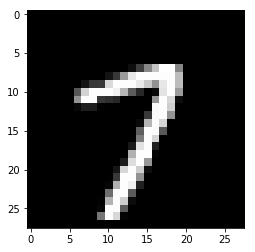

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

#view data

plt.imshow(rtrX[(N*10)-1].reshape(28,28), cmap=plt.get_cmap('gray')); #need cmap thing or else is weird colour
print(rtrY[(N*10)-1])

In [7]:
print(np.unique(rtrY, return_counts=True)) #making sure there's N of each

(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.]), array([10, 10, 10, 10, 10, 10, 10, 10, 10, 10]))


In [8]:
def random_shift(X, max_shift=3):

    X = np.copy(X)
    
    n_pixels = np.random.randint(0,max_shift+1,4) #args are low, max, n, with max being exclusive, i.e. 0, 5, 4 produces 4 numbers between 0 and 4
    
    #shifting image up by n_pixels
    if n_pixels[0]:
        X[:-n_pixels[0]*28] = X[n_pixels[0]*28:]
        X[-n_pixels[0]*28:] = np.zeros(n_pixels[0]*28)
        
    #shifting image right by n_pixels
    if n_pixels[1]:
        X = X.reshape(28,28)
        X[:,n_pixels[1]:] = X[:,:-n_pixels[1]]
        X[:,:n_pixels[1]] = np.zeros((28,n_pixels[1]))
        X = X.reshape(28*28)
        
    #shifting image down by n_pixels
    if n_pixels[2]:
        X[n_pixels[2]*28:] = X[:-n_pixels[2]*28]
        X[:n_pixels[2]*28] = np.zeros(n_pixels[2]*28)
        
    #shifting image left by n_pixels
    if n_pixels[3]:
        X = X.reshape(28,28)
        X[:,:-n_pixels[3]] = X[:,n_pixels[3]:]
        X[:,-n_pixels[3]:] = np.zeros((28,n_pixels[3]))
        X = X.reshape(28*28)
    
    return X

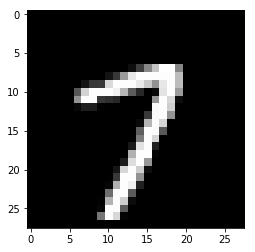

In [9]:
plt.imshow(rtrX[(N*10)-1].reshape(28,28), cmap=plt.get_cmap('gray')); #need cmap thing or else is weird colour

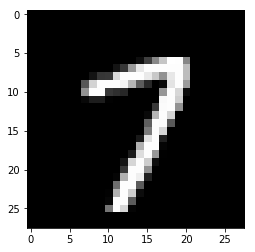

In [10]:
plt.imshow(random_shift(rtrX[(N*10)-1]).reshape(28,28), cmap=plt.get_cmap('gray')); #need cmap thing or else is weird colour

In [23]:
import torch
from torch.utils.data import Dataset

class RMNIST(Dataset):
    
    def __init__(self, X, y, shift=None):
        assert len(X) == len(y)
        self.X = X
        self.y = y
        self.shift = shift
        
        
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img = self.X[idx]
        label = self.y[idx]
        if self.shift:
            img = self.shift(img)
        img = img.reshape(28, 28)
        img = torch.FloatTensor(img)
        return (img, label)

In [24]:
batch_size = 10

train_dataset = RMNIST(rtrX, rtrY)

train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

(100, 784)
100


In [25]:
import torch
import torch.nn as nn

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
        
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x)
        x = self.fc2(x)
        return x

In [26]:
model = Net()

lr = 0.1
momentum = 0
batch_size = 10
epochs = 200

In [27]:
import torch.optim as optim

for epoch in range(1, epochs+1):
    
    optimizer = optim.SGD(model.parameters(), lr=lr*((0.8)**(epoch/10+1)), momentum=momentum)
    
    for i, (X, y) in enumerate(train_loader):
        #do stuff
        pass

got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got


got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got


got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got


got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got


got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got


got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got


got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got


got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
got
